In [2]:
import numpy as np
from numpy.linalg import norm

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401  – keeps 3‑D backend alive

import dynamic_tasker.rotations as rot
from dynamic_tasker.constants import Constants
from dynamic_tasker.areas import *
import dynamic_tasker.orbits as orbits
import datetime
from tqdm import tqdm

import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage[T1]{fontenc}
    \usepackage{XCharter}
    \usepackage[charter,vvarbb,scaled=1.05]{newtxmath}
'''

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [3]:
# Set up the scene
h = 400
spacecraft_coords = np.array([0, 0, Constants.R_E + h])/Constants.R_E  # Spacecraft coordinates in ECEF
orbit = orbits.circular_orbit(h + Constants.R_E, 0, 0, 0, 0)  # Circular orbit at altitude h
# Earth at origin
O = np.array([0, 0, 0])
field_of_regard = 45

hfov = 30  # Horizontal field of view in degrees
vfov = 30  # Vertical field of view in degrees

def camera_corner_vectors_from_fov(hfov, vfov):
    hfov_rad = np.radians(hfov)
    vfov_rad = np.radians(vfov)
    camera_vectors = np.array([
    [np.tan(hfov_rad), np.tan(vfov_rad), -1],  # Top right corner
    [-np.tan(hfov_rad), np.tan(vfov_rad), -1],  # Top left corner
    [-np.tan(hfov_rad), -np.tan(vfov_rad), -1],  # Bottom left corner
    [np.tan(hfov_rad), -np.tan(vfov_rad), -1]   # Bottom right corner
    ])
    return camera_vectors

def camera_plane_vectors_from_fov(hfov, vfov):
    hfov_rad = np.radians(hfov)
    vfov_rad = np.radians(vfov)
    camera_vectors = np.array([
    [np.tan(hfov_rad), 0, -1],  # Right
    [-np.tan(hfov_rad), 0, -1],  # Left
    [0, np.tan(vfov_rad), -1],  # Top
    [0, -np.tan(vfov_rad), -1]   # Bottom
    ])
    return camera_vectors

def plane_normals_from_corners(corner_vectors, boresight=None):
    """
    Return four unit normals that all point INTO the camera’s field of view.

    Parameters
    ----------
    corner_vectors : (4,3) array_like
        Rays to the image corners, ordered clockwise or counter-clockwise.
    boresight : (3,) array_like or None
        Vector that points into the FoV.  If None, (0,0,-1) is assumed.

    Notes
    -----
    The old heuristic (`n[2] > 0`) only works when the boresight is –Z
    in the *same* frame.  The rule below generalises that:  
    “flip the normal when it has a **negative dot product** with the
    boresight.”
    """
    # close the loop: v0, v1, v2, v3, v0
    cv = np.asarray(corner_vectors, dtype=float)
    cv_loop = np.vstack([cv, cv[0]])

    # default boresight if none supplied
    if boresight is None:
        b = np.array([0.0, 0.0, -1.0])
    else:
        b = np.asarray(boresight, dtype=float)
        b /= norm(b)

    normals = []
    for i in range(4):
        n = np.cross(cv_loop[i], cv_loop[i + 1])
        # flip if n points AWAY from the boresight
        if np.dot(n, b) < 0:         # <-- one-line change
            n = -n
        normals.append(n / norm(n))

    return np.array(normals)

def rotate_camera_vectors(camera_vectors, roll, pitch, yaw):
    """
    Rotate a set of 3D vectors by roll (about X), pitch (about Y), then yaw (about Z).
    Angles are in degrees.  camera_vectors is an (N,3) array or (3,) vector.
    """
    # ensure array shape (N,3)
    vecs = np.asarray(camera_vectors, dtype=float)
    orig_shape = vecs.shape
    if vecs.ndim == 1:
        vecs = vecs[np.newaxis, :]

    # Convert angles to radians
    r, p, y = np.radians([roll, pitch, yaw])

    # Rotation about X axis (roll)
    Rx = np.array([
        [1,        0,         0],
        [0, np.cos(r), -np.sin(r)],
        [0, np.sin(r),  np.cos(r)]
    ])

    # Rotation about Y axis (pitch)
    Ry = np.array([
        [ np.cos(p), 0, np.sin(p)],
        [         0, 1,        0],
        [-np.sin(p), 0, np.cos(p)]
    ])

    # Rotation about Z axis (yaw)
    Rz = np.array([
        [np.cos(y), -np.sin(y), 0],
        [np.sin(y),  np.cos(y), 0],
        [        0,         0,  1]
    ])

    # Combined: first roll, then pitch, then yaw
    R = Rz @ Ry @ Rx

    # Apply and restore original shape
    rotated = (R @ vecs.T).T
    return rotated.reshape(orig_shape)

camera_corner_vectors = rotate_camera_vectors(camera_corner_vectors_from_fov(hfov, vfov), 0, -45, 0) 
camera_plane_vectors = rotate_camera_vectors(camera_plane_vectors_from_fov(hfov, vfov), 0, -45, 0)

plane_normals = plane_normals_from_corners(camera_corner_vectors)  # Get the normals of the planes
print("Camera corner vectors:")
print(camera_corner_vectors)

print("Plane normals:")
print(plane_normals)
camera_vectors = np.concatenate((camera_corner_vectors, camera_plane_vectors), axis=0)  # Stack the corner and plane vectors
# Nice! The camera vectors are now rotated


Camera corner vectors:
[[ 1.11535507  0.57735027 -0.29885849]
 [ 0.29885849  0.57735027 -1.11535507]
 [ 0.29885849 -0.57735027 -1.11535507]
 [ 1.11535507 -0.57735027 -0.29885849]]
Plane normals:
[[ 0.35355339 -0.8660254  -0.35355339]
 [-0.96592583  0.         -0.25881905]
 [ 0.35355339  0.8660254  -0.35355339]
 [-0.25881905 -0.         -0.96592583]]


[[ 0.35355339 -0.8660254  -0.35355339]
 [-0.96592583  0.         -0.25881905]
 [ 0.35355339  0.8660254  -0.35355339]
 [-0.25881905 -0.         -0.96592583]]


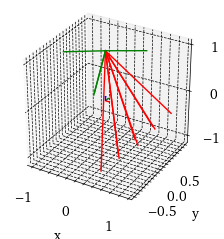

In [4]:
# Plot camera to make sure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
spacecraft_coords = np.array([0, 0, 1 + h/Constants.R_E])  # Spacecraft coordinates in ECEF

for c in camera_vectors:
    plt.plot([spacecraft_coords[0], c[0]], [spacecraft_coords[1], c[1]], [spacecraft_coords[2], c[2]], 'r-')

# Plot the normals
print(plane_normals)
for n in plane_normals:
    plt.plot([spacecraft_coords[0], spacecraft_coords[0] + n[0]], 
             [spacecraft_coords[1], spacecraft_coords[1] + n[1]], 
             [spacecraft_coords[2], spacecraft_coords[2] + n[2]], 'g-')


# optionally, add arrowheads
arrow_len = 0.1 #* max(x_hi-x_lo, y_hi-y_lo, z_hi-z_lo)
ax.quiver(0, 0, 0,  1, 0, 0, length=arrow_len, color='r', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0,  0, 1, 0, length=arrow_len, color='g', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0,  0, 0, 1, length=arrow_len, color='b', arrow_length_ratio=0.2)

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
ax.set_box_aspect([1,1,1])

plt.show()


Horizon spherical angle (degrees): 19.782270649752228
Horizon angle (degrees): 70.21772935024777
Field of regard spherical angles (degrees): 3.716432900140529
0.9409855414576571
Field of regard distances (km): 0.06481851599015899
0.04450511125960299


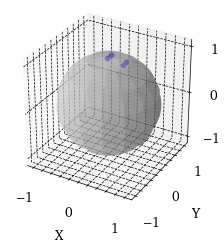

In [5]:
# Now, plot the total possible area of the track within the field of regard
# Working with max constraints
# Only look positive (+x)
circle_pos = (np.array([1, 0, 0]), np.deg2rad(90)) # 90 degrees in +x direction

# Now, horizon
horizon_angle = orbits.horizon_spherical_angle(orbit)
print("Horizon spherical angle (degrees):", np.rad2deg(horizon_angle))
circle_horizon = (np.array([0, 0, 1]), horizon_angle)
    
def roll2spherical_angle(angle, h):
    R = Constants.R_E
    theta = np.radians(angle)
    return np.sign(theta) * np.arccos(((R + h) * (np.sin(theta)) ** 2 + np.cos(theta) * np.sqrt(R**2 - ((R + h)**2) * (np.sin(theta) ** 2)))/(R))

def roll2crosstrack(angle, h):
    return Constants.R_E * roll2spherical_angle(angle, h)

print("Horizon angle (degrees):", np.degrees(orbits.horizon_angle(orbit)))
field_of_regard = 45
# The two field of regard circles
print("Field of regard spherical angles (degrees):", np.degrees(roll2spherical_angle(field_of_regard, h)))
for_spherical = np.degrees(roll2spherical_angle(field_of_regard, h))
for_dist = np.sin(np.radians(for_spherical))

horizon_dist_vertical = np.cos(horizon_angle)
print(horizon_dist_vertical)
print("Field of regard distances (km):", for_dist)

constant_planes = []

constant_planes.append({'n': np.array([1, 0, 0]), 'd': 0.0 })
constant_planes.append({'n': np.array([0, -1, 0]), 'd': -for_dist})
constant_planes.append({'n': np.array([0, 1, 0]), 'd': -for_dist})
constant_planes.append({'n': np.array([0, 0, 1]), 'd': horizon_dist_vertical})

verts, planes, edge_idxs = vertex_set_from_planes(constant_planes)
area = spherical_polygon_area(verts, planes, edge_idxs)
print(area)

# Plot all the vertices...
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

u = np.linspace(0, 2 * np.pi, 60)
v = np.linspace(0, np.pi, 30)
x_s = np.outer(np.cos(u), np.sin(v))
y_s = np.outer(np.sin(u), np.sin(v))
z_s = np.outer(np.ones_like(u), np.cos(v))

# plot the sphere
ax.plot_surface(
    x_s, y_s, z_s,
    rstride=4, cstride=4,
    color='lightgray', alpha=0.5,
    linewidth=0
)

for v in verts:
    ax.scatter(v[0], v[1], v[2], color='b', s=10)
plt.show()


[array([0.        , 0.00823943, 0.99996606]), array([ 0.        , -0.06481852,  0.99789707]), array([ 0.0429533 , -0.06481852,  0.9969722 ]), array([0.0413098 , 0.01201525, 0.99907414])]
Area of the polygon (sr): 0.0031358935162691115


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


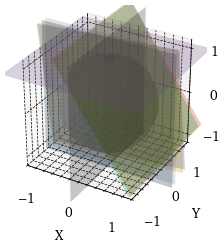

In [6]:
def plane_from_spacecraft_pos(spacecraft_coords, normals):
    camera_planes = []
    for i in range(len(normals)):
        d = np.dot(spacecraft_coords, normals[i])
        camera_planes.append({'n': normals[i], 'd': d})  
    return camera_planes


# OK! Now add all the camera vectors to the circles
hfov = 1
vfov = 1
pitch = -34
roll = 10

# Calculate a boresight
boresight = spacecraft_coords + 0.01 * rotate_camera_vectors(np.array([0, 0, -1]), roll, pitch, 0)  # Rotate the boresight vector

camera_plane_vectors = rotate_camera_vectors(camera_plane_vectors_from_fov(hfov, vfov), roll, pitch, 0)
camera_corner_vectors = rotate_camera_vectors(camera_corner_vectors_from_fov(hfov, vfov), roll, pitch, 0)
camera_plane_normals = plane_normals_from_corners(camera_corner_vectors)  # Get the normals of the planes
camera_planes = plane_from_spacecraft_pos(spacecraft_coords, camera_plane_normals)
camera_planes.append({'n': np.array([0, 0, 1]), 'd': horizon_dist_vertical})
camera_planes.append({'n': np.array([1, 0, 0]), 'd': 0.0 })
camera_planes.append({'n': np.array([0, -1, 0]), 'd': -for_dist})
camera_planes.append({'n': np.array([0, 1, 0]), 'd': -for_dist})

interior_point = np.array([0.01, 0, 1])
# Calculate the actual boresight here


planes = camera_planes

verts, planes, edge_idxs = vertex_set_from_planes(planes)
area = spherical_polygon_area(verts, planes, edge_idxs)
print(verts)
print("Area of the polygon (sr):", area)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 1) Plot unit sphere
u = np.linspace(0, 2 * np.pi, 60)
v = np.linspace(0, np.pi, 30)
x_s = np.outer(np.cos(u), np.sin(v))
y_s = np.outer(np.sin(u), np.sin(v))
z_s = np.outer(np.ones_like(u), np.cos(v))

ax.plot_surface(x_s, y_s, z_s, rstride=4, cstride=4,
                color='lightgray', alpha=0.5, linewidth=0)

# 2) Plot all planes (camera + constant)
all_planes = camera_planes + constant_planes
grid_extent = 1.5
res = 20

for plane in planes:
    n = np.array(plane['n'])
    d = plane['d']

    # Pick a point on the plane
    x0 = d * n

    # Build two in‐plane orthonormal dirs
    arb = np.array([1.0, 0.0, 0.0]) if abs(n[0]) < abs(n[1]) else np.array([0.0, 1.0, 0.0])
    u_dir = np.cross(n, arb);  u_dir /= np.linalg.norm(u_dir)
    v_dir = np.cross(n, u_dir)

    # Create S×T grid
    s = np.linspace(-grid_extent, grid_extent, res)
    t = np.linspace(-grid_extent, grid_extent, res)
    S, T = np.meshgrid(s, t)
    P = x0[None,None,:] + S[:,:,None]*u_dir[None,None,:] + T[:,:,None]*v_dir[None,None,:]
    X, Y, Z = P[:,:,0], P[:,:,1], P[:,:,2]

    # Draw the full plane patch
    ax.plot_surface(X, Y, Z, alpha=0.25, linewidth=0, shade=True)

# 3) Scatter intersection verts
for vert in verts:
    ax.scatter(vert[0], vert[1], vert[2], color='b', s=20)

# 4) Connect verts in sequence to outline the polygon
#    (assumes `verts` are in polygon order)
if len(verts) > 1:
    for i in range(len(verts)):
        v0 = verts[i]
        v1 = verts[(i+1) % len(verts)]
        ax.plot([v0[0], v1[0]], 
                [v0[1], v1[1]], 
                [v0[2], v1[2]],
                color='r', linewidth=2)

# 5) Clip view to your region of interest
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_zlim(-1.2, 1.2)

plt.show()





In [7]:
def calculate_spacecraft_for_coverage(h, roll, pitch, yaw, hfov, vfov, field_of_regard=45):
    # Calculate the camera vectors based on the given roll, pitch, and yaw angles
    camera_corner_vectors = rotate_camera_vectors(camera_corner_vectors_from_fov(hfov, vfov), roll, -pitch, yaw) 
    camera_plane_vectors = rotate_camera_vectors(camera_plane_vectors_from_fov(hfov, vfov), roll, -pitch, yaw)
    boresight_vec = rotate_camera_vectors(np.array([0,0,-1]), roll, -pitch, yaw)
    camera_plane_normals = plane_normals_from_corners(camera_corner_vectors, boresight_vec)  # Get the normals of the planes
    camera_planes = plane_from_spacecraft_pos(spacecraft_coords, camera_plane_normals)
    
    for_spherical = np.degrees(roll2spherical_angle(field_of_regard, h))
    for_dist = np.sin(np.radians(for_spherical))

    horizon_dist_vertical = np.cos(horizon_angle)

    constant_planes = []

    constant_planes.append({'n': np.array([1, 0, 0]), 'd': 0.0 })
    constant_planes.append({'n': np.array([0, -1, 0]), 'd': -for_dist})
    constant_planes.append({'n': np.array([0, 1, 0]), 'd': -for_dist})
    constant_planes.append({'n': np.array([0, 0, 1]), 'd': horizon_dist_vertical})

    all_planes = camera_planes + constant_planes
    verts, planes, edge_idxs = vertex_set_from_planes(all_planes)
    area = spherical_polygon_area(verts, planes, edge_idxs)
    return area, verts

In [8]:
# Example usage
area, verts = calculate_spacecraft_for_coverage(400, 0, 0, 0, 70, 70, field_of_regard=45)

# Calculate for a variety of hfov, vfov...

hfov = np.linspace(1, 70, 100)
vfov = np.linspace(1, 70, 100)

results = np.zeros((len(hfov), len(vfov)))

for i, h in tqdm(enumerate(hfov)):
    for j, v in enumerate(vfov):
        results[i, j], verts = calculate_spacecraft_for_coverage(400, 0, h/2, 0, h, v, field_of_regard=45)
        # 




100it [00:11,  8.49it/s]


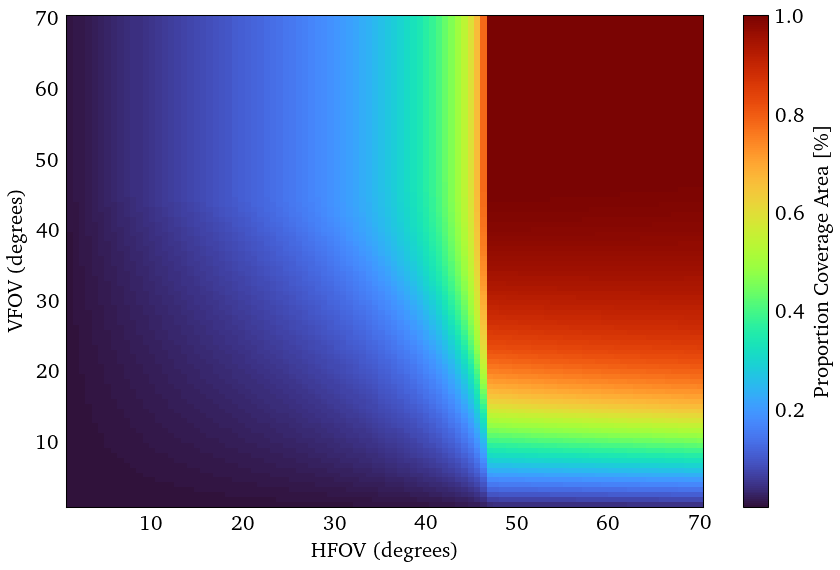

In [9]:
# Plot the results
fig, ax = plt.subplots(dpi=150, figsize=(6, 4))
c = ax.pcolormesh(hfov, vfov, (results.T)/np.max(results[:]), cmap='turbo')
ax.set_xlabel('HFOV (degrees)')
ax.set_ylabel('VFOV (degrees)')
# ax.set_title('Coverage Area')
cbar = fig.colorbar(c, ax=ax, label='Proportion Coverage Area [\%]')
plt.tight_layout()
# plt.savefig("coverage_area.pdf")
plt.show()

In [10]:
# Calculate the minimum hfov to cover the entire for..

# Calculate the horizontal distance
# horizontal half dist = np.tan(hfov/2) * distance
# horizon_distance = from library
# min_hfov_half_angle = np.arcsin(horizontal_half_dist/horizon_distance)

field_of_regard = 45
h = 400

horizontal_half_dist = np.tan(np.deg2rad(field_of_regard)) * (((Constants.R_E + h) * (np.cos(np.deg2rad(field_of_regard))**2)) \
    - np.cos(np.deg2rad(field_of_regard)) * np.sqrt((Constants.R_E) ** 2 - (Constants.R_E + h) ** 2 * (np.sin(np.deg2rad(field_of_regard))**2)))

horizon_distance = orbits.horizon_distance(orbit)
min_hfov_half_angle = np.arcsin(horizontal_half_dist/horizon_distance)
min_hfov_angle = 2 * np.degrees(min_hfov_half_angle)

print(min_hfov_angle)

def is_for_edge_visible(verts):
    return np.any([np.isclose(x[1], -0.06481852) for x in verts])

print(is_for_edge_visible(verts))


20.76460188888879
True


In [11]:
# Calculate for a variety of hfov, vfov...
hfov_roll = np.linspace(55, 70, 100)
vfov_roll = np.linspace(55, 70, 100)

results = np.zeros((len(hfov_roll), len(vfov_roll)))

verts_list = []

for i, h in tqdm(enumerate(hfov_roll)):
    for j, v in enumerate(vfov_roll):
        area, verts = calculate_spacecraft_for_coverage(400, 45, h/2, 0, h, v, field_of_regard=45)
        results[i, j] = is_for_edge_visible(verts)
        verts_list.append((h, v, verts))

100it [00:12,  8.09it/s]


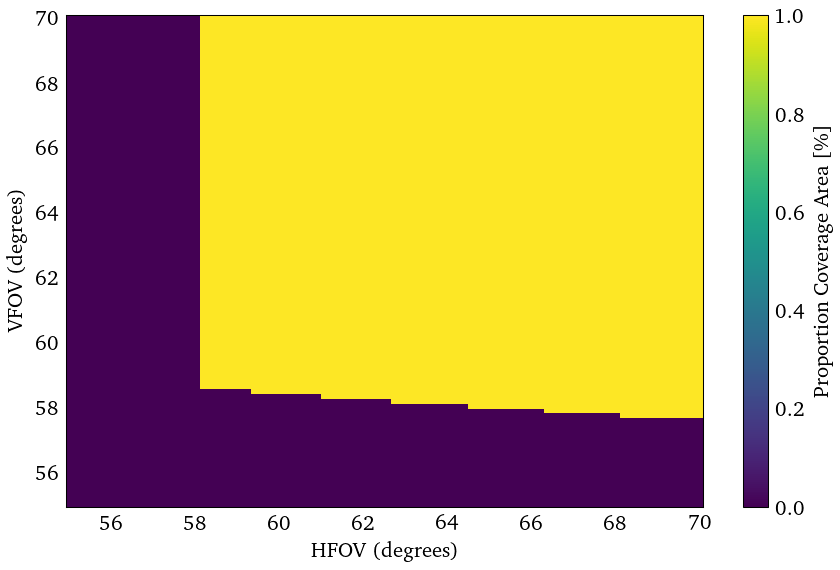

In [12]:
# Plot the results
fig, ax = plt.subplots(dpi=150, figsize=(6, 4))
c = ax.pcolormesh(hfov_roll, vfov_roll, (results.T))
ax.set_xlabel('HFOV (degrees)')
ax.set_ylabel('VFOV (degrees)')
# ax.set_title('Coverage Area')
cbar = fig.colorbar(c, ax=ax, label='Proportion Coverage Area [\%]')
plt.tight_layout()
# plt.savefig("coverage_area.pdf")
plt.show()

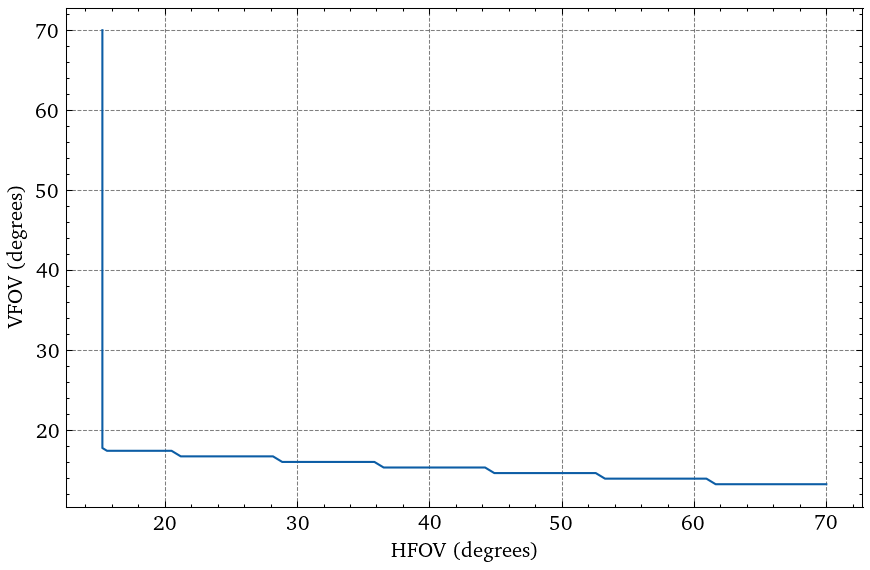

In [13]:
from skimage import measure

# make sure it’s float, and mask shape is (Ny, Nx)
mask = (results.T > 0.5).astype(float)
contours = measure.find_contours(mask, 0.5)

fig, ax = plt.subplots(dpi=150, figsize=(6,4))
for contour in contours:
    # contour is an array of (row, col) float indices;
    # map to your hfov/vfov axes:
    xx = np.interp(contour[:,1], np.arange(len(hfov)), hfov)
    yy = np.interp(contour[:,0], np.arange(len(vfov)), vfov)
    ax.plot(xx, yy, '-')

ax.set_xlabel('HFOV (degrees)')
ax.set_ylabel('VFOV (degrees)')
plt.tight_layout()
plt.show()


In [24]:
# This is a half FOV and half-angle
def subtending_angle_from_fov(fov, h):
    sign = np.sign(fov)
    angle = np.abs(fov)
    
    beta = np.pi - np.arcsin((Constants.R_E + h)/(Constants.R_E) * np.sin(angle)) # obtuse angle
    
    theta = np.pi - (angle + beta)
    return theta * sign

def calc_lookahead_time(angle, h):
    thetadot = np.sqrt(Constants.mu / (((Constants.R_E+h)) ** 3)) # Angular motion over Earth
    max_angle = np.arcsin(Constants.R_E / (Constants.R_E+h))
    
    if(angle > max_angle):
        angle = max_angle - 1e-9
        
    lookahead_subtending_angle = subtending_angle_from_fov(angle, h) 

    return lookahead_subtending_angle / thetadot 

def calc_arbitrary_for_constraint(angle, orbit):
    # Calculate dist to point on alongtrack
    h = orbit.a - Constants.R_E
    if(angle < np.rad2deg(orbits.horizon_angle(orbit))):
        alongtrack_spherical = roll2spherical_angle(angle, h)
        alongtrack_dist = np.sin((alongtrack_spherical)) * (Constants.R_E)
        alongtrack_diag_dist = np.sqrt(alongtrack_dist**2 + horizontal_half_dist**2)
        
        # Calculate the spherical angle of the diag distance
        crosstrack_spherical = roll2spherical_angle(field_of_regard, h)
        crosstrack_dist = np.sin((crosstrack_spherical)) * (Constants.R_E)
    
        diag_flat_dist = np.sqrt(alongtrack_dist**2 + crosstrack_dist**2)

        full_spherical = np.arcsin(diag_flat_dist / Constants.R_E)

        # Calculate the full dist to the track
        full_dist = np.sqrt(alongtrack_diag_dist**2 + (h + (1 - np.cos((full_spherical))) * Constants.R_E)**2)
    else:
        full_dist = orbits.horizon_distance(orbit)

    # Now, calculate the hfov requirement...

    return 2 * np.rad2deg(np.arcsin(horizontal_half_dist / full_dist))
    

9.783868913342832


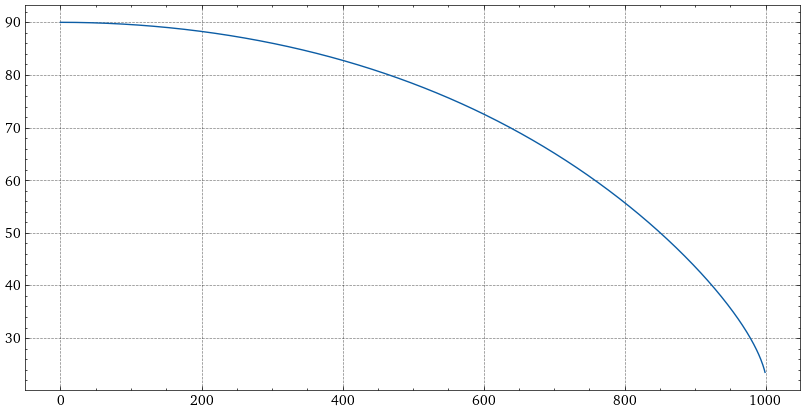

In [15]:
# Ok, now extending the plot into 3 dimensions...

# lookahead_time_1d = calc_lookahead_time([x for x in vfov], 400)

# This is the minimum hfov requirement based on a given vfov
lookahead_arbitrary_for = [calc_arbitrary_for_constraint(x, orbit) for x in np.linspace(0, 70, 1000)]

plt.figure(figsize=(10, 5))
plt.plot(lookahead_arbitrary_for)
plt.show()

(100, 100)


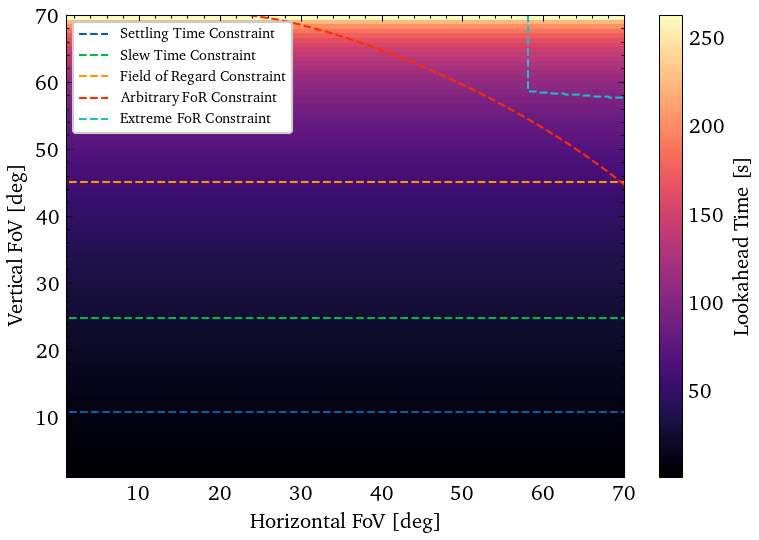

In [22]:
# Plot a heatmap of the lookahead time
lookahead_time_1d = [calc_lookahead_time(np.deg2rad(x), 400) for x in vfov]

# Repeat it...
lookahead_time_2d = np.tile(lookahead_time_1d, (len(hfov), 1))

print(lookahead_time_2d.shape)
# Ultra agile case
# field_of_regard = 45
# t_s = 5
# t_slew = 15

# Agile case
field_of_regard = 45
t_s = 10
t_slew = 25

# Find the fov that corresponds to the slew time constraint
# Find the fov that corresponds to the slew time constraint
# For t_s constraint
vfov_t_s = None
for v in vfov:
    if calc_lookahead_time(np.deg2rad(v), 400) >= t_s:
        vfov_t_s = v
        break

# For t_slew constraint  
vfov_t_slew = None
for v in vfov:
    if (x := calc_lookahead_time(np.deg2rad(v), 400)) >= t_slew:
        vfov_t_slew = v
        break

fig, ax = plt.subplots(dpi=150, figsize=(6, 4))
c = ax.imshow(lookahead_time_2d.T, cmap='magma', extent=[1, 70, 1, 70], origin='lower', aspect='auto')
ax.set_xlabel('Horizontal FoV [deg]')
ax.set_ylabel('Vertical FoV [deg]')
cbar = fig.colorbar(c, ax=ax, label='Lookahead Time [s]')
# Plot the constraints...
plt.plot([0, 80], [vfov_t_s, vfov_t_s], linestyle="dashed", label="Settling Time Constraint") # Settling time
plt.plot([0, 80], [vfov_t_slew, vfov_t_slew], linestyle="dashed", label="Slew Time Constraint") # Slew time
# Field of regard constraint
plt.plot([0, 80], [field_of_regard, field_of_regard], linestyle="dashed", label="Field of Regard Constraint") # Field of regard

# Arbitrary for constraint
lookahead_arbitrary_for = [calc_arbitrary_for_constraint(x, orbit) for x in vfov]
plt.plot(lookahead_arbitrary_for, vfov, label="Arbitrary FoR Constraint", linestyle="dashed")

mask = (results.T > 0.5).astype(float)
contours = measure.find_contours(mask, 0.5)

for contour in contours:
    # contour is an array of (row, col) float indices;
    # map to your hfov/vfov axes:
    xx = np.interp(contour[:,1], np.arange(len(hfov_roll)), hfov_roll)
    yy = np.interp(contour[:,0], np.arange(len(vfov_roll)), vfov_roll)
    ax.plot(xx, yy, '--', label='Extreme FoR Constraint', color='tab:cyan')

plt.legend(fontsize=7, ncol = 1, loc='upper left')
plt.xlim(1, 70)
plt.ylim(1, 70)
plt.grid()

plt.savefig("fli_fov_constraints_3D_agile.pdf")
plt.show()